In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from scikeras.wrappers import KerasClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold

In [18]:
X_train = np.load("../Data/X_train.npy", allow_pickle=True).T
X_test = np.load("../Data/X_test.npy", allow_pickle=True).T
y_train = np.load("../Data/y_train.npy", allow_pickle=True)
y_test = np.load("../Data/y_test.npy", allow_pickle=True)

#print(X_train.shape)
#selector = VarianceThreshold()
#X_train = selector.fit_transform(X_train)
#X_test = selector.transform(X_test)

#print(X_train.shape)


In [19]:
def create_model(model_type, input_dim=None, **kwargs):
    if model_type == 'neural_network':
        inputs = Input(shape=(input_dim, ))
        x = Dense(64, input_dim=input_dim, activation='relu')(inputs)
        x = Dropout(0.5)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(1, activation='sigmoid')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**kwargs)
    elif model_type == 'svm':
        model = SVC(probability=True, **kwargs)
    elif model_type == 'xgboost':
        model = xgb.XGBClassifier(eval_metric='logloss', **kwargs)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    return model

In [20]:
def train_model(X_train, y_train, model_type, epochs=100, batch_size=32, validation_split=0.1, **kwargs):
    input_dim = X_train.shape[1]
    model = create_model(model_type, input_dim, **kwargs)
    
    if model_type in ['neural_network']:
        def lr_schedule(epoch):
            return 0.001 * (0.1 ** int(epoch / 10))
        #lr_scheduler = LearningRateScheduler(lr_schedule)
        
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            validation_split=validation_split,
            #callbacks=[lr_scheduler],
            verbose=1  # Set to 0 for no output, 1 for progress bar, 2 for one line per epoch
        )
    else:
        # For non-TensorFlow models
        model.fit(X_train, y_train)
        history = None
    
    return model, history

In [21]:
def train_model_feature_selection(X_train, y_train, X_test, model_type, epochs=100, batch_size=32, validation_split=0.1, **kwargs):
    selector = VarianceThreshold()
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    # Select top k features
    k = min(250, X_train.shape[1])  # Ensure k is not larger than the number of features
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    input_dim = X_train_selected.shape[1]
    model = create_model(model_type, input_dim=input_dim, **kwargs)
    if model_type in ['neural_network']:
        def lr_schedule(epoch):
            return 0.001 * (0.1 ** int(epoch / 10))
        #lr_scheduler = LearningRateScheduler(lr_schedule)
        
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        history = model.fit(
            X_train_selected, y_train,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            validation_split=validation_split,
            #callbacks=[lr_scheduler],
            verbose=1  # Set to 0 for no output, 1 for progress bar, 2 for one line per epoch
        )
    return model, history, X_test_selected
    
    

In [22]:
def plot_training_history(history, metrics=None):
    """
    Plot training history of a TensorFlow model.
    
    :param history: History object returned by model.fit()
    :param metrics: List of metrics to plot (optional). If None, plots all available metrics.
    """
    if not isinstance(history, dict):
        history = history.history

    epochs = range(1, len(next(iter(history.values()))) + 1)

    if metrics is None:
        metrics = [m for m in history.keys() if not m.startswith('val_')]

    plt.figure(figsize=(12, 4 * len(metrics)))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(len(metrics), 1, i)
        
        plt.plot(epochs, history[metric], 'bo-', label=f'Training {metric}')
        if f'val_{metric}' in history:
            plt.plot(epochs, history[f'val_{metric}'], 'ro-', label=f'Validation {metric}')
        
        plt.title(f'{metric.capitalize()} vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        
        if metric == 'loss':
            plt.yscale('log')  # Use log scale for loss

    plt.tight_layout()
    plt.show()

In [23]:
def test_model(model, X_test, y_test, model_type):
    """
    Test the model on the test set and return various performance metrics.
    """
    # Make predictions
    if model_type in ['neural_network']:
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Ensure y_pred and y_test are 1D arrays
    y_pred = np.ravel(y_pred)
    y_test = np.ravel(y_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Use zero_division parameter to handle undefined cases
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Only calculate AUC-ROC if there are two classes in the predictions
    unique_classes = np.unique(y_pred)
    if len(unique_classes) == 2:
        auc_roc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc_roc = None
    
    # For TensorFlow models, also get the loss
    if model_type in ['neural_network']:
        loss = model.evaluate(X_test, y_test)[0]
    else:
        loss = None
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'loss': loss,
        'confusion_matrix': cm
    }
    
    # Print additional information
    print("Confusion Matrix:")
    print(cm)
    print(f"Unique predicted classes: {unique_classes}")
    print(f"Prediction shape: {y_pred.shape}")
    print(f"Prediction dtype: {y_pred.dtype}")
    print(f"Prediction first few values: {y_pred[:10]}")
    print(f"Prediction distribution: {np.bincount(y_pred.astype(int))}")
    print(f"True label shape: {y_test.shape}")
    print(f"True label dtype: {y_test.dtype}")
    print(f"True label first few values: {y_test[:10]}")
    print(f"True label distribution: {np.bincount(y_test.astype(int))}")
    
    return results

In [24]:
model, history = train_model(X_train, y_train, model_type='neural_network', epochs=100)

Epoch 1/100


/Users/calwetzel/.pyenv/versions/Edgevanta/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5343 - loss: 12390.3730 - val_accuracy: 0.6506 - val_loss: 356.5509
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5543 - loss: 2085.7185 - val_accuracy: 0.6024 - val_loss: 98.2591
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4262 - loss: 783.4191 - val_accuracy: 0.3735 - val_loss: 136.3669
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2742 - loss: 320.9052 - val_accuracy: 0.3253 - val_loss: 22.3716
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2730 - loss: 10.9151 - val_accuracy: 0.3253 - val_loss: 19.6923
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2672 - loss: 3.0425 - val_accuracy: 0.3253 - val_loss: 14.8693
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2632 - loss: 1.2039 - val_accuracy: 0.3253 - val_loss: 14.4217
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2654 - loss: 1.5781 -

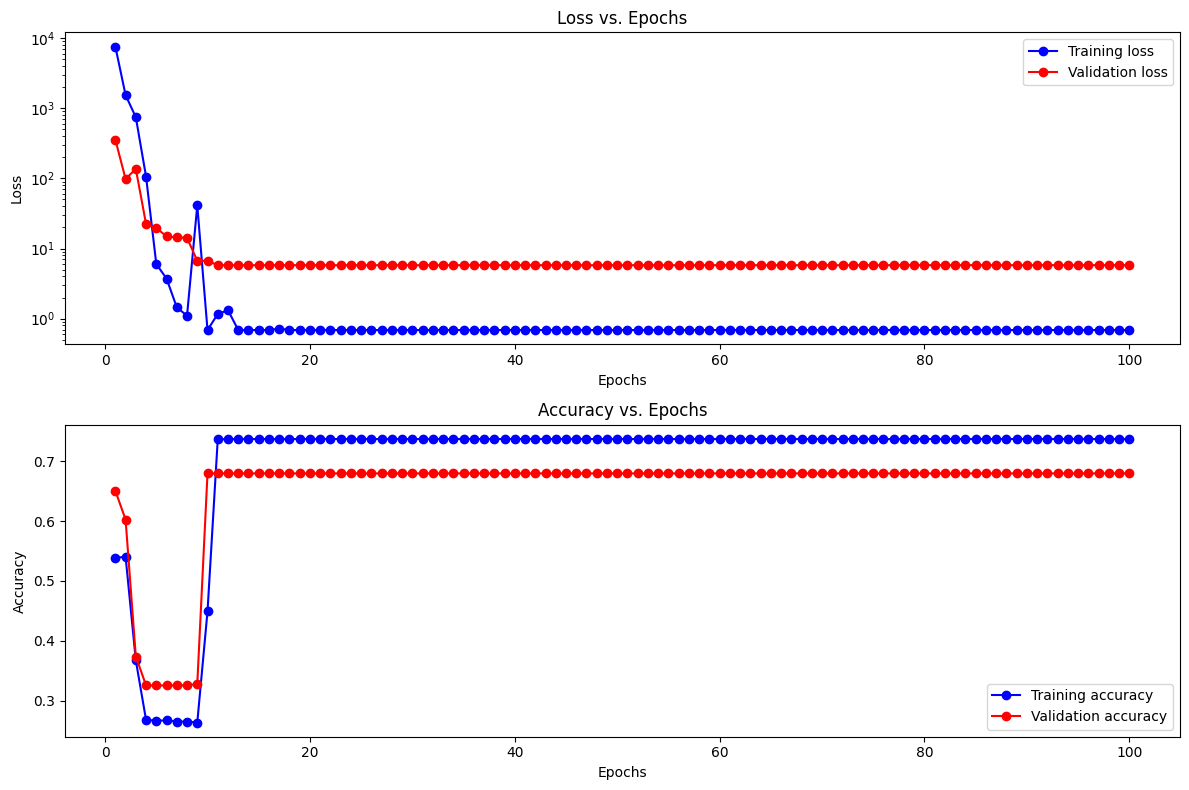

In [25]:
plot_training_history(history, metrics=['loss', 'accuracy'])

In [26]:
test_results = test_model(model, X_test, y_test, model_type='neural_network')
for metric, value in test_results.items():
    if metric != 'confusion_matrix':
        print(f"{metric}: {value}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.6986 - loss: 0.6809
Confusion Matrix:
[[325   0]
 [134   2]]
Unique predicted classes: [0 1]
Prediction shape: (461,)
Prediction dtype: int64
Prediction first few values: [0 0 0 0 0 0 0 0 0 0]
Prediction distribution: [459   2]
True label shape: (461,)
True label dtype: float16
True label first few values: [0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
True label distribution: [325 136]
accuracy: 0.7093275488069414
precision: 1.0
recall: 0.014705882352941176
f1_score: 0.028985507246376812
auc_roc: 0.5103846153846153
loss: 0.6826415061950684


In [27]:
model, history, X_test_feature_selection = train_model_feature_selection(X_train, y_train, X_test, model_type='neural_network', epochs=250)

Epoch 1/250


/Users/calwetzel/.pyenv/versions/Edgevanta/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5142 - loss: 26699.5879 - val_accuracy: 0.5349 - val_loss: 3247.8120
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.5069 - loss: 9133.6045 - val_accuracy: 0.4458 - val_loss: 684.7570
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.4785 - loss: 3435.5254 - val_accuracy: 0.5325 - val_loss: 84.1753
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.5396 - loss: 1311.6036 - val_accuracy: 0.6892 - val_loss: 26.9008
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.4748 - loss: 1651.6654 - val_accuracy: 0.4410 - val_loss: 11.2458
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5136 - loss: 406.9618 - val_accuracy: 0.6602 - val_loss: 1.5491
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.4882 - loss: 297.9001 - val_accuracy: 0.6313 - val_loss: 5.3065
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.

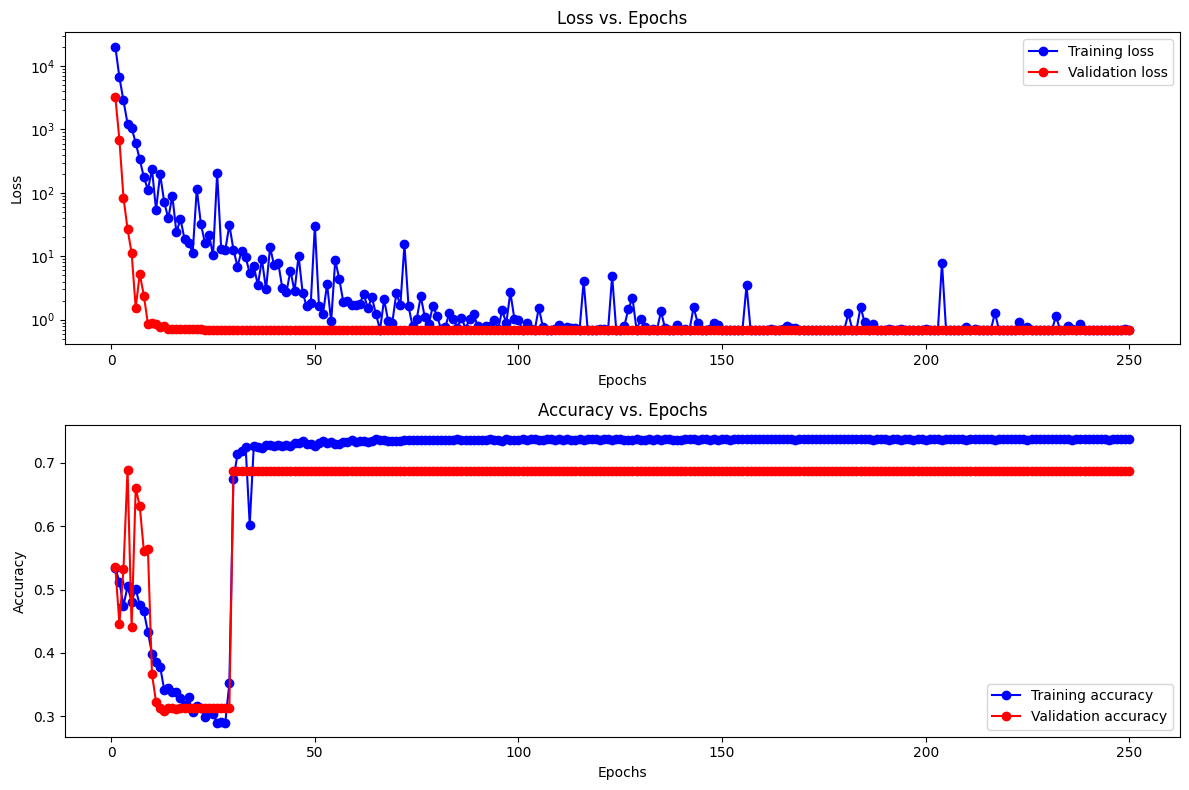

In [28]:
plot_training_history(history, metrics=['loss', 'accuracy'])

In [29]:
test_results = test_model(model, X_test_feature_selection, y_test, model_type='neural_network')
for metric, value in test_results.items():
    print(f"{metric}: {value}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.6909 - loss: 0.6884
Confusion Matrix:
[[325   0]
 [136   0]]
Unique predicted classes: [0]
Prediction shape: (461,)
Prediction dtype: int64
Prediction first few values: [0 0 0 0 0 0 0 0 0 0]
Prediction distribution: [461]
True label shape: (461,)
True label dtype: float16
True label first few values: [0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
True label distribution: [325 136]
accuracy: 0.7049891540130152
precision: 0.0
recall: 0.0
f1_score: 0.0
auc_roc: None
loss: 0.6880518794059753
confusion_matrix: [[325   0]
 [136   0]]


In [32]:
model, history = train_model(X_train, y_train, model_type='xgboost', epochs=100)
test_results = test_model(model, X_test, y_test, model_type='xgboost')
for metric, value in test_results.items():
    print(f"{metric}: {value}")

Confusion Matrix:
[[304  21]
 [106  30]]
Unique predicted classes: [0 1]
Prediction shape: (461,)
Prediction dtype: int64
Prediction first few values: [0 0 0 0 0 0 1 0 0 0]
Prediction distribution: [410  51]
True label shape: (461,)
True label dtype: float16
True label first few values: [0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
True label distribution: [325 136]
accuracy: 0.7245119305856833
precision: 0.5882352941176471
recall: 0.22058823529411764
f1_score: 0.32085561497326204
auc_roc: 0.7083484162895928
loss: None
confusion_matrix: [[304  21]
 [106  30]]


In [30]:
model, history = train_model(X_train, y_train, model_type='random_forest', epochs=100)
test_results = test_model(model, X_test, y_test, model_type='random_forest')
for metric, value in test_results.items():
    print(f"{metric}: {value}")

Confusion Matrix:
[[322   3]
 [133   3]]
Unique predicted classes: [0. 1.]
Prediction shape: (461,)
Prediction dtype: float16
Prediction first few values: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
Prediction distribution: [455   6]
True label shape: (461,)
True label dtype: float16
True label first few values: [0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
True label distribution: [325 136]
accuracy: 0.7049891540130152
precision: 0.5
recall: 0.022058823529411766
f1_score: 0.04225352112676056
auc_roc: 0.6585972850678734
loss: None
confusion_matrix: [[322   3]
 [133   3]]


In [31]:
model, history = train_model(X_train, y_train, model_type='svm', epochs=100)
test_results = test_model(model, X_test, y_test, model_type='svm')
for metric, value in test_results.items():
    print(f"{metric}: {value}")

Confusion Matrix:
[[325   0]
 [136   0]]
Unique predicted classes: [0.]
Prediction shape: (461,)
Prediction dtype: float16
Prediction first few values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediction distribution: [461]
True label shape: (461,)
True label dtype: float16
True label first few values: [0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
True label distribution: [325 136]
accuracy: 0.7049891540130152
precision: 0.0
recall: 0.0
f1_score: 0.0
auc_roc: None
loss: None
confusion_matrix: [[325   0]
 [136   0]]
